In [1]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'screening' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.1 -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++
src/main.cpp:789:20: warning: unused variable 'val' [-Wunused-variable]
            double val = 1


In [2]:
import argparse
import os
import numpy as np
from scipy.fftpack import dctn, idctn
import math
import sys
import copy
import matplotlib.pyplot as plt
from screening import HelperClass

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)

# Poisson solver with Neumann boundary conditions

Solving the following problem on the domain $\Omega= [0,1]^2$,
$$- \Delta u = f $$
$$ \partial_n u = g $$
where
$$ f(x,y) = \cos(\pi x + C) \cos(\pi y + C) $$
$$ u(x,y) = \frac{1}{(2\pi)^2}\cos(\pi x + C) \cos(\pi y + C) $$
$$ g_x(x,y) = - \frac{1}{4\pi} \sin(\pi x + C)\cos(\pi y + C) $$
$$ g_y(x,y) = - \frac{1}{4\pi} \cos(\pi x + C)\sin(\pi y + C) $$

Text(0.5, 1.0, 'initial density')

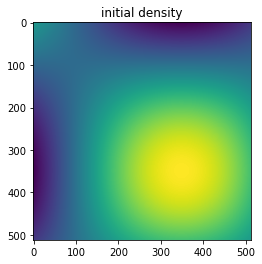

In [3]:
# Poisson Solver
# Solving -\Delta u = f with a boundary condition \partial_n u = g (Neummann)
n = 512
f = np.zeros((n,n))
u = np.zeros_like(f)
X, Y = np.meshgrid(np.linspace(0.5/n,1-0.5/n,n), np.linspace(0.5/n,1-0.5/n,n))
yMax = 5
X*=yMax
Y*=yMax
C = 1
f = np.cos(X/yMax * np.pi + C) * np.cos(Y/yMax * np.pi + C)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(f)
ax.set_title("initial density")

In [4]:
# Initialize Fourier kernel
def initialize_kernel(n1, n2, dy):
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    # kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel = 2*(1-np.cos(xx))/(dy*dy) + 2*(1-np.cos(yy))/(dy*dy)
    kernel[0,0] = 1     # to avoid dividing by zero
    return kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')

# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# Solving Poisson
#   - Δ u = f
#   output: u = (-Δ)⁻¹ f
def solve_poisson(u, f, kernel):
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

def solve_poisson_bdry(u, f, bdry, kernel):
    gx0, gx1, gy0, gy1 = bdry
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace[0,:]   -= gy0 * n
    workspace[n-1,:] += gy1 * n
    workspace[:,0]   -= gx0 * n
    workspace[:,n-1] += gx1 * n
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

In [5]:
x0 = 0
x1 = 1
y0 = 0
y1 = 1
xx = np.linspace(0.5/n,1-0.5/n,n)
gy0 = -1.0/(2.0*np.pi) * np.cos(np.pi * xx + C) * np.sin(np.pi * y0 +  C)
gy1 = -1.0/(2.0*np.pi) * np.cos(np.pi * xx + C) * np.sin(np.pi * y1 +  C)
gx0 = -1.0/(2.0*np.pi) * np.sin(np.pi * x0 + C) * np.cos(np.pi * xx +  C)
gx1 = -1.0/(2.0*np.pi) * np.sin(np.pi * x1 + C) * np.cos(np.pi * xx +  C)


Text(0.5, 1.0, 'error: 3.822657908006847e-12')

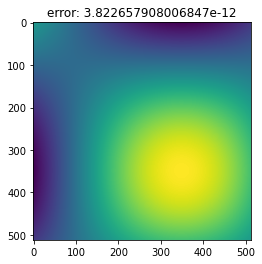

In [6]:
# Testing poisson solver
kernel = initialize_kernel(n, n, 1.0/n*yMax)
solve_poisson_bdry(u,f,[gx0,gx1,gy0,gy1],kernel)
plt.imshow(u)
plt.title(f"error: {np.mean( (u - u.mean() - (f - f.mean()) * (0.5/(np.pi/yMax)**2))**2 )}")

# c-transform

$$ \phi^c(x) = \inf_y c(x,y) + \phi(y) $$

$$ c(x,y) = \frac12 |y|^2$$

$$ \phi^c(x) = \inf_y \frac12 |y|^2 + \phi(y) $$

In [7]:
# centered difference
def compute_dx(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[1:-1,0]    = phi[:,0]
  # tmp[1:-1,-1]   = phi[:,-1]
  # tmp[1:-1,1:-1] = phi
  A = np.zeros_like(phi)
  A[:,1:-1] = (phi[:,2:] - phi[:,:-2])/(2.0*dy)
  A[:,0]    = (phi[:,1] - phi[:,0])/(1.0*dy)
  A[:,-1]   = (phi[:,-1] - phi[:,-2])/(1.0*dy)
  return A

def compute_dx_forward(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[:,:-1] = (phi[:,1:] - phi[:,:-1])/(1.0*dy)
  A[:,-1]  = (phi[:,-1] - phi[:,-2])/(1.0*dy)
  return A

def compute_dx_back(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[:,1:] = (phi[:,1:] - phi[:,:-1])/(1.0*dy)
  A[:,0]  = (phi[:,1]  - phi[:,0])/(1.0*dy)
  return A

def compute_dxx(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[1:-1,0]    = phi[:,0]
  # tmp[1:-1,-1]   = phi[:,-1]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[1:-1,2:] + tmp[1:-1,:-2] - 2.0 * tmp[1:-1,1:-1])/(dy*dy)

  A = compute_dx_forward(phi, tmp, dy)
  return compute_dx_back(A, tmp, dy)

# centered difference
def compute_dy(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[0,1:-1]    = phi[0,:]
  # tmp[-1,1:-1]   = phi[-1,:]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[2:,1:-1] - tmp[:-2,1:-1])/(2.0*dy)

  A = np.zeros_like(phi)
  A[1:-1,:] = (phi[2:,:] - phi[:-2,:])/(2.0*dy)
  A[0,:]    = (phi[1,:] - phi[0,:])/(1.0*dy)
  A[-1,:]   = (phi[-1,:] - phi[-2,:])/(1.0*dy)
  return A

def compute_dy_forward(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[:-1,:] = (phi[1:,:] - phi[:-1,:])/(1.0*dy)
  A[-1,:]  = (phi[-1,:] - phi[-2,:])/(1.0*dy)
  return A

def compute_dy_back(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[1:,:] = (phi[1:,:] - phi[:-1,:])/(1.0*dy)
  A[0,:]  = (phi[1,:] - phi[0,:])/(1.0*dy)
  return A

def compute_dyy(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[0,1:-1]    = phi[0,:]
  # tmp[-1,1:-1]   = phi[-1,:]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[2:,1:-1] + tmp[:-2,1:-1] - 2.0 * tmp[1:-1,1:-1])/(dy*dy)

  A = compute_dy_forward(phi, tmp, dy)
  return compute_dy_back(A, tmp, dy)

# centered difference
def compute_dxy(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[0,0]     = phi[0,0]
  # tmp[0,-1]    = phi[0,-1]
  # tmp[-1,0]    = phi[-1,0]
  # tmp[-1,-1]   = phi[-1,-1]
  # tmp[1:-1,0]  = phi[:,0]
  # tmp[1:-1,-1] = phi[:,-1]
  # tmp[0,1:-1]  = phi[0,:]
  # tmp[-1,1:-1] = phi[-1,:]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[2:,2:] - tmp[2:,:-2] - tmp[:-2,2:] + tmp[:-2,:-2])/(4.0*dy*dy)
  # A = compute_dx_back(phi, tmp, dy)
  A = np.zeros_like(phi)
  A[:-1,:-1] = (phi[1:,1:] - phi[1:,:-1] - phi[:-1,1:] + phi[:-1,:-1])/(dy*dy)
  A[-1,:-1]  = - (phi[-1,:-1] - phi[-1,1:] - phi[-2,:-1] + phi[-2,1:])  /(dy*dy)
  A[:-1,-1]  = - (phi[:-1,-1] - phi[:-1,-2] - phi[1:,-1] + phi[1:,-2])/(dy*dy)
  A[-1,-1]   = (phi[-1,-1] - phi[-1,-2] - phi[-2,-1] + phi[-2,-2])/(dy*dy)
  return A

In [8]:
from screening import compute_dx, compute_dy, c_transform_cpp, c_transform_forward_cpp,compute_first_variation_cpp #, approx_push_cpp

# performing c transform
# output: modified psi
def c_transform(psi, phi, cost):
  n = psi.shape[0]
  m = phi.shape[0]
  psi[:] = np.min(cost + phi.reshape((1,m*m)), axis=1).reshape((n,n))

def c_transform_eps(psi, phi, cost, epsilon: float, dy: float):
  n = psi.shape[0]
  m = phi.shape[0]
  psi[:] = - epsilon * np.log(( np.exp((- phi.reshape((1,n*n)) - cost) / epsilon) ).sum(axis=1)* (dy*dy) ).reshape((n,n))  # mat = (n*n, n*n) matrix

def c_transform_forward(phi, psi, cost):
  n = psi.shape[0]
  m = phi.shape[0]
  phi[:] = np.max(- cost + psi.reshape((n*n,1)), axis=0).reshape((m,m))

# push forward
def approx_push(nu, psi, phi, cost, epsilon: float, dx: float, dy: float):
  n = psi.shape[0]
  m = phi.shape[0]
  mat   = np.exp((psi.reshape((n*n,1)) - phi.reshape((1,m*m)) - cost) / epsilon) # mat = (n*n, n*n) matrix
  mat  /= np.sum(mat, axis=1).reshape((n*n,1)) * (dy*dy)
  nu[:] = np.sum(mat, axis=0).reshape((m,m)) * (dx*dx)


def compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=False):
  n = phi_np.shape[0]

  #   initialize fx, fy
  fx = np.zeros((phi_np.shape[0], phi_np.shape[1]))
  fy = np.zeros((phi_np.shape[0], phi_np.shape[1]))
  compute_dx(fx, phi_np-b, dy)
  compute_dy(fy, phi_np-b, dy)

  R1 = np.zeros((phi_np.shape[0],phi_np.shape[1]))
  R2 = np.zeros((phi_np.shape[0],phi_np.shape[1]))
  R1x = np.zeros((phi_np.shape[0],phi_np.shape[1]))
  R2y = np.zeros((phi_np.shape[0],phi_np.shape[1]))

  helper.compute_inverse_g(R1, R2, phi_np, psi_np, fx, fy)

  R1 = nu_np * R1
  R2 = nu_np * R2

  compute_dx(R1x, R1, dy)
  compute_dy(R2y, R2, dy)

  gx0 = R1[:,0]
  gx1 = R1[:,-1]

  gy0 = R2[0,:]
  gy1 = R2[-1,:]

  return nu_np + R1x + R2y, [gx0,gx1,gy0,gy1]


def solve_poisson(u, phi_np, psi_np, nu_np, b, kernel, helper, dx, dy, yMax, show_image=False):
  rhs, bdry = compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=show_image) # computing the right hand side
  solve_poisson_bdry(u,rhs,bdry,kernel)
  return rhs

size of cost:  (900, 3600)


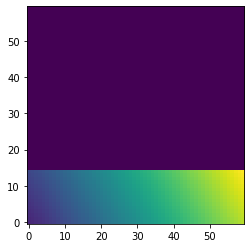

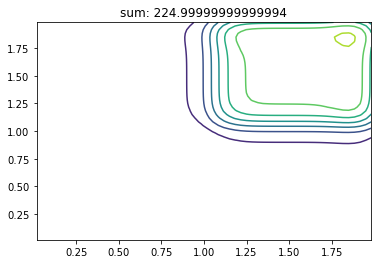

In [11]:

from IPython import display

# parameters
# grid size n x n
n = 30
m = 60

# step size for the gradient ascent
L = 100

# epsilon for pushforward
epsilon = 5e-2
max_iteration = 100000
Xx,Xy =np.meshgrid(np.linspace(1+0.5/n,2-0.5/n,n), np.linspace(1+0.5/n,2-0.5/n,n))
yMax = 2
Yx,Yy =np.meshgrid(np.linspace(yMax*0.5/m,yMax*(1-0.5/m),m), np.linspace(yMax*0.5/m,yMax*(1-0.5/m),m))

dx = 1.0/n
dy = dx * yMax

kernel = initialize_kernel(m, m, dy)

Xv = np.zeros((n*n,2))
Xv[:,0] = Xx.reshape((n*n,))
Xv[:,1] = Xy.reshape((n*n,))

Yv = np.zeros((m*m,2))
Yv[:,0] = Yx.reshape((m*m,))
Yv[:,1] = Yy.reshape((m*m,))

cost = - np.sum(Xv.reshape((n*n,1,2)) * Yv.reshape((1,m*m,2)),axis=2)
print("size of cost: ", cost.shape)
b    = 0.5 * (Yx**2 + Yy**2)

psi_np = (- 0.5*(Xx**2+Xy**2)).astype('float64')
phi_checking = np.zeros((m,m))
c_transform_forward_cpp(phi_checking, psi_np, cost)
plt.imshow(phi_checking,origin='lower')
plt.show()

phi_np = np.zeros((m,m)).astype('float64')
nu_np  = np.zeros((m,m)).astype('float64')

c_transform_forward(phi_np, psi_np, cost)
approx_push(nu_np, psi_np, phi_np, cost, 1e-2, dx, dy)

plt.contour(Yx,Yy,nu_np, origin='lower')
plt.title(f"sum: {np.sum(nu_np)}")
plt.show()

helper = HelperClass(phi_np, dx, dy)

u = np.zeros((m,m)).astype('float64')

  0%|          | 0/100000 [00:00<?, ?it/s]

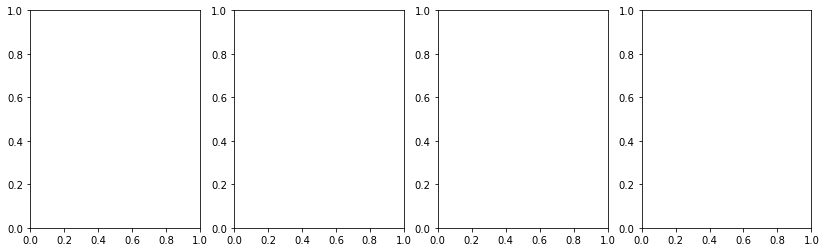

/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


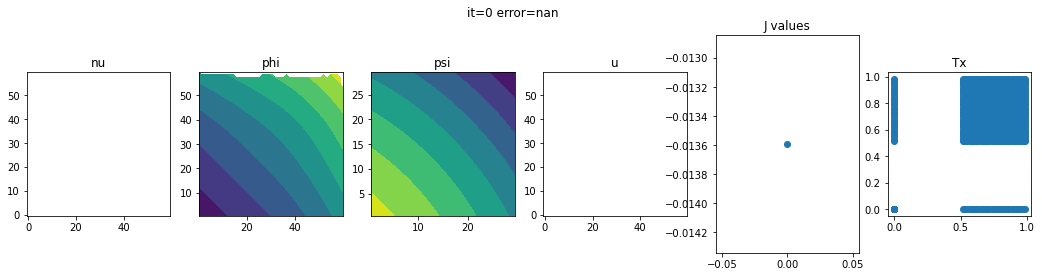

  0%|          | 9/100000 [00:01<3:09:36,  8.79it/s] /Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


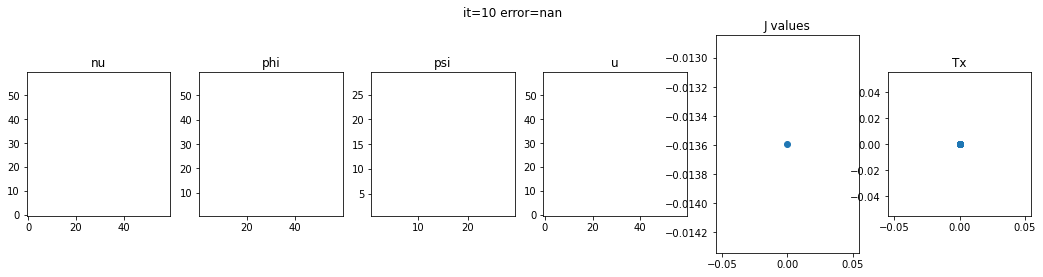

  0%|          | 19/100000 [00:03<2:37:02, 10.61it/s]

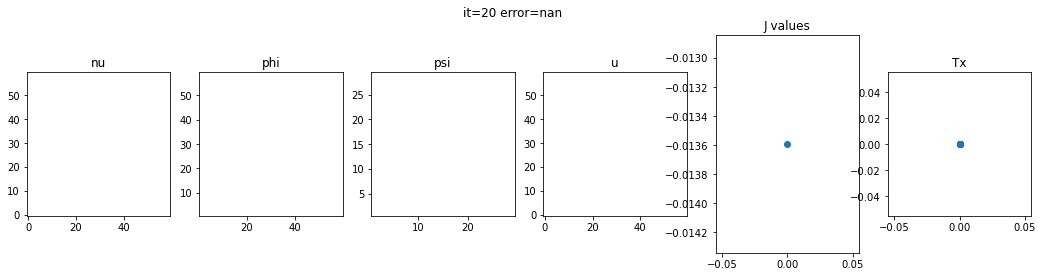

  0%|          | 29/100000 [00:04<2:34:22, 10.79it/s]

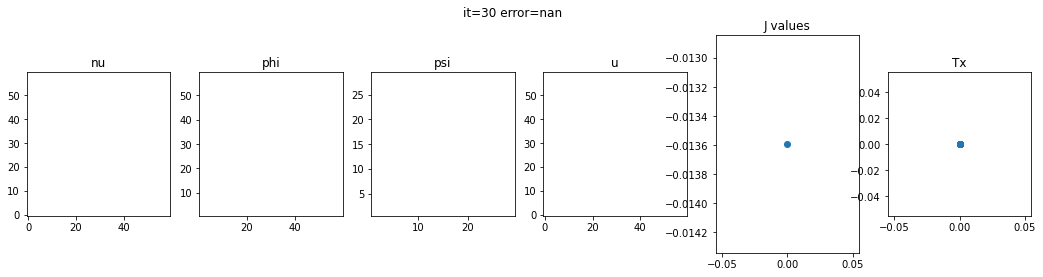

  0%|          | 39/100000 [00:05<2:32:58, 10.89it/s]

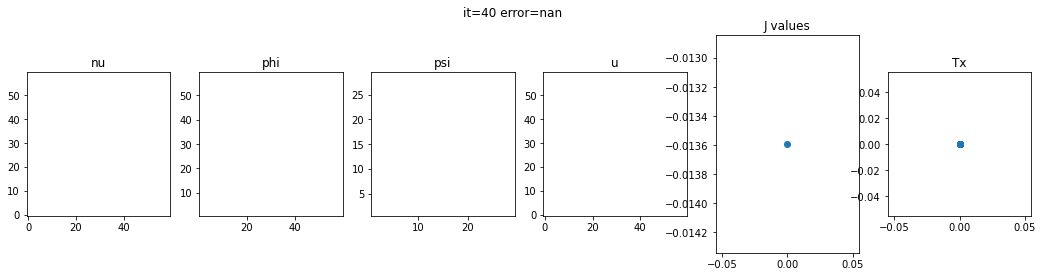

  0%|          | 49/100000 [00:07<2:49:53,  9.81it/s]

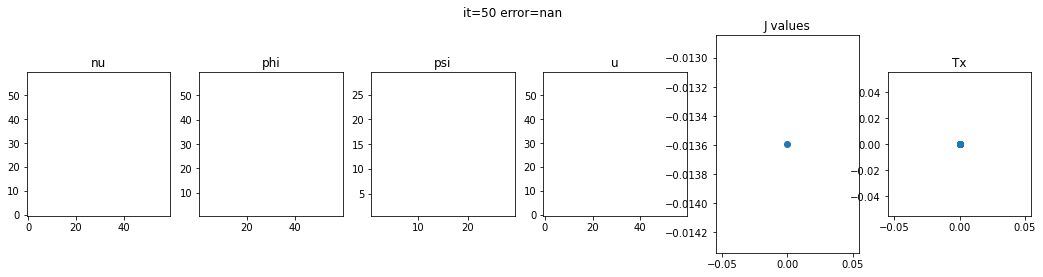

  0%|          | 60/100000 [00:09<4:10:51,  6.64it/s]


KeyboardInterrupt: 

In [12]:
import tqdm
import cv2

# phi_np = np.load('phi.npy')
# phi_np = cv2.resize(phi_np, dsize=(n, n), interpolation=cv2.INTER_CUBIC)
# rhs = np.zeros((n,n))

# phi_np = 

fig,ax = plt.subplots(1,4,figsize=(14,4))
pbar = tqdm.tqdm(range(max_iteration))

J_list = []

for it in pbar:
  # c transform
  c_transform(psi_np, phi_np, cost)
  # c_transform_eps(psi_np, phi_np, cost, 1e-2, dy)

  # print(f"min: {torch.min(psi_np.view((n*n,1)) - phi_np.view((1,n*n)) - cost)} max: {torch.max(psi_np.view((n*n,1)) - phi_np.view((1,n*n)) - cost)}")

  # pushforward mu -> nu
  approx_push(nu_np, psi_np, phi_np, cost, 1e-2, dx, dy)
  rhs = solve_poisson(u, phi_np, psi_np, nu_np, b, kernel, helper, dx, dy, yMax, show_image = (it%10==0))
  # # # TODO check if nu is solved. check phi and psi stay smooth.


  # find the value of J
  J_val = ((phi_np - b) * nu_np).sum() * dy*dy
  J_list.append(J_val)

  # fdfd
  Tx = np.zeros((phi_np.shape[0], phi_np.shape[1]))
  Ty = np.zeros((phi_np.shape[0], phi_np.shape[1]))
  compute_dx(Tx, psi_np, dy)
  compute_dy(Ty, psi_np, dy)

  Tx = -Tx; Ty = -Ty

  # compute_first_variation_cpp(rhs, psi_np, phi_np, nu_np, cost, b,  dx,  dy,  yMax)

  # # gradient ascent
  error = np.mean(rhs**2)/L**2
  phi_np += 1.0/L * rhs

  if error == np.nan:
    print("wrong values")
    break

  if it % 10 == 0:
    approx_push(nu_np, psi_np, phi_np, cost, 1e-4, dx, dy)
    fig,ax = plt.subplots(1,6,figsize=(18,4))
    ax[0].imshow(nu_np,origin='lower')
    ax[0].set_title("nu")
    ax[1].contourf(phi_np,origin='lower')
    ax[1].set_aspect('equal')
    ax[1].set_title("phi")
    ax[2].contourf(psi_np,origin='lower')
    ax[2].set_aspect('equal')
    ax[2].set_title("psi")
    ax[3].imshow(u,origin='lower')
    ax[3].set_title("u")
    ax[4].plot(J_list, 'o-')
    ax[4].set_title("J values")
    ax[5].scatter(Tx,Ty)
    ax[5].set_aspect('equal')
    ax[5].set_title('Tx')
    plt.suptitle(f"it={it} error={error:0.2e}")
    plt.show()
    # plt.savefig(f"images/{it//10:03d}.png")
    # hdisplay.update(fig)
    # plt.close('all')


    # fix,ax = plt.subplots(1,1)
    # A=psi.view((1,n*n)) - phi.view((n*n,1)) - cost
    # A = A.detach().cpu().numpy()
    # ax.imshow(A)
    # ax.set_title(f"{np.max(A)} {np.min(A)}")
    # plt.show()

In [ ]:
import glob
import cv2

img_array = []
for filename in glob.glob('./images/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

from IPython.display import Video
Video("project.mp4")

In [ ]:
!rm images/*
